In [6]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os
import cv2
import numpy as np
class CenterDataset(Dataset):
    def __init__(self, csv_file, image_dir, split='TRAIN', transform=None):
        self._data = pd.read_csv(csv_file)
        self._data = self._data[self._data['Split'] == split].reset_index(drop=True)
        self._data['FileName'] = self._data['FileName'].astype(str).str.strip()
        self.image_dir = image_dir
        self.transform = transform

    @property
    def data(self):
        return self._data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        filename = row['FileName'].strip()
        if not filename.endswith('.png'):
            filename += '.png'
        image_path = self.image_dir + filename

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # ensure 1-channel
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = image.astype('float32') / 255.0  # normalize manually if not using transforms
        image = np.expand_dims(image, axis=0)    # [1, 112, 112]
        image = torch.tensor(image, dtype=torch.float32)

        # Safe label extraction
        label = torch.tensor([float(row['x']), float(row['y'])], dtype=torch.float32)
        label /= 112.0  # normalize coordinates

        return image, label



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CenterNet(nn.Module):
    def __init__(self):
        super(CenterNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> [16, 56, 56]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> [32, 28, 28]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> [64, 14, 14]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                           # -> [64, 1, 1]
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),                 # -> [64]
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)              # -> [centerX, centerY]
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x


In [7]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

train_dataset = CenterDataset(csv_file="filelist_frames_dataset.csv", image_dir="/Users/bennosteinegger/.cache/kagglehub/datasets/foghorn/echonet-frames-masks-dataset/versions/1/Echonet-Frames-Masks-Dataset/", split="TRAIN", transform=transform)
val_dataset = CenterDataset(csv_file="filelist_frames_dataset.csv", image_dir="/Users/bennosteinegger/.cache/kagglehub/datasets/foghorn/echonet-frames-masks-dataset/versions/1/Echonet-Frames-Masks-Dataset/", split="VAL", transform=transform)
test_dataset = CenterDataset(csv_file="filelist_frames_dataset.csv", image_dir="/Users/bennosteinegger/.cache/kagglehub/datasets/foghorn/echonet-frames-masks-dataset/versions/1/Echonet-Frames-Masks-Dataset/", split="TEST", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [9]:
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CenterNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
    return val_loss / len(loader.dataset)

# Training loop
for epoch in range(20):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 1: Train Loss = 0.0124, Val Loss = 0.0030
Epoch 2: Train Loss = 0.0032, Val Loss = 0.0030
Epoch 3: Train Loss = 0.0032, Val Loss = 0.0029
Epoch 4: Train Loss = 0.0031, Val Loss = 0.0029
Epoch 5: Train Loss = 0.0031, Val Loss = 0.0033
Epoch 6: Train Loss = 0.0030, Val Loss = 0.0027
Epoch 7: Train Loss = 0.0030, Val Loss = 0.0028
Epoch 8: Train Loss = 0.0029, Val Loss = 0.0026
Epoch 9: Train Loss = 0.0027, Val Loss = 0.0028
Epoch 10: Train Loss = 0.0025, Val Loss = 0.0022
Epoch 11: Train Loss = 0.0024, Val Loss = 0.0021
Epoch 12: Train Loss = 0.0023, Val Loss = 0.0020
Epoch 13: Train Loss = 0.0021, Val Loss = 0.0023
Epoch 14: Train Loss = 0.0021, Val Loss = 0.0018
Epoch 15: Train Loss = 0.0020, Val Loss = 0.0021
Epoch 16: Train Loss = 0.0019, Val Loss = 0.0017
Epoch 17: Train Loss = 0.0019, Val Loss = 0.0022
Epoch 18: Train Loss = 0.0018, Val Loss = 0.0017
Epoch 19: Train Loss = 0.0018, Val Loss = 0.0017
Epoch 20: Train Loss = 0.0017, Val Loss = 0.0016


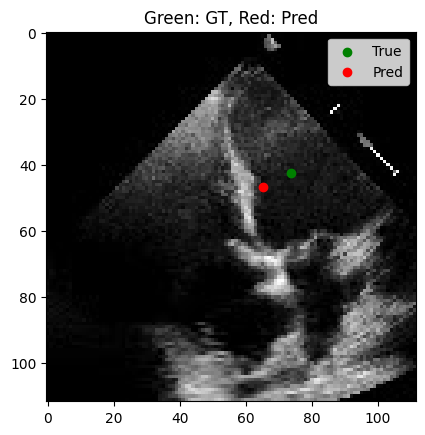

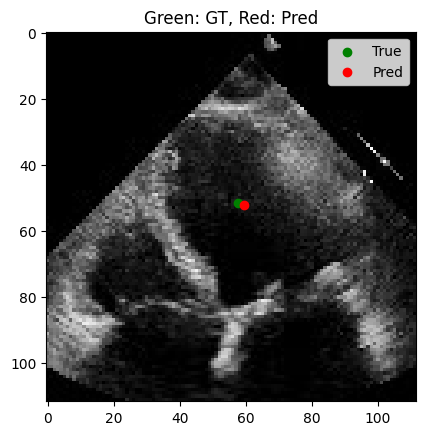

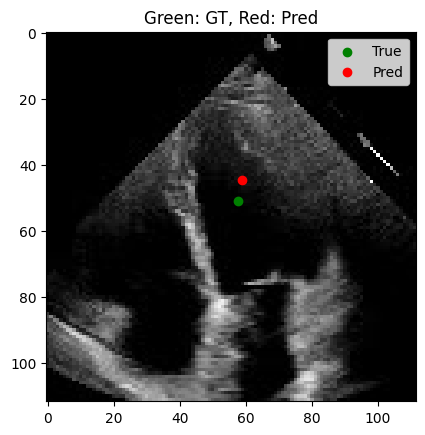

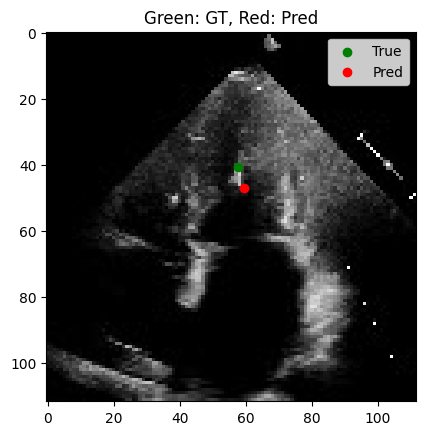

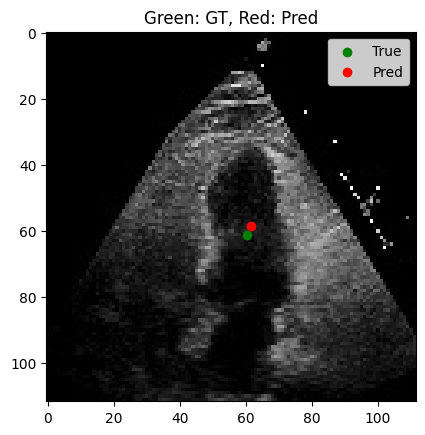

In [10]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, num_samples=5):
    model.eval()
    samples = 0

    with torch.no_grad():
        for images, labels in loader:
            preds = model(images.to(device)).cpu().numpy()
            labels = labels.numpy()
            images = images.numpy()

            for i in range(len(images)):
                img = images[i][0]  # [1, 112, 112] -> [112, 112]
                pred_x, pred_y = preds[i] * 112
                true_x, true_y = labels[i] * 112

                plt.imshow(img, cmap='gray')
                plt.scatter([true_x], [true_y], color='green', label='True')
                plt.scatter([pred_x], [pred_y], color='red', label='Pred')
                plt.title(f"Green: GT, Red: Pred")
                plt.legend()
                plt.show()

                samples += 1
                if samples >= num_samples:
                    return
# Load model for testing
#model = CenterNet().to(device)
#model.load_state_dict(torch.load("center_model.pth"))
#model.eval()
visualize_predictions(model, test_loader, num_samples=5)

In [11]:
# Save model weights only
torch.save(model.state_dict(), "center_model.pth")
